## Training a NN using differents methods
### Author: Leonardo Bravo

## Abstract
In this notebook, it trains a Bayesian NN using pytorch. And it compares differents methods for training it. It trys different methods: conventional ELBO and Alpha divergence. It compares obtained results and arguments possible differences between methods.

# Loading libraries

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
from tqdm.notebook import tqdm

# Bayesian Neural Network using recent algorithms for VI

Consider the following synthetic data for classification

<IPython.core.display.Javascript object>


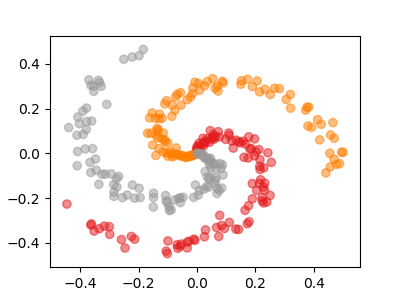

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='int') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0, 0.5, N) # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

#X, y = sklearn.datasets.make_moons(200, noise=0.2)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, alpha=0.5);

## Passing data format to numpy

In [5]:
x_train = torch.from_numpy(X.astype('float32'))
y_train = torch.from_numpy(y)

# Activities

- Implement a bayesian neural network (BNN) model using Pyro
- Train the model using the conventional ELBO objective
- Obtain and visualize the predictive posterior in data space
- Compare with the [$\alpha$ divergence objective](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.renyi_elbo.RenyiELBO), explore the influence of $\alpha$ in the results
- Compare with the [SVGD estimator](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.svgd.SVGD) with RBF kernel, explore the influence of the kernel parameters 

## Implement a bayesian neural network (BNN) model using Pyro

It implements a very basic NN using 1 hidden layer.

In [6]:
from pyro.nn import PyroSample, PyroModule
from pyro.distributions import Normal, Categorical

class leo_bayesian(PyroModule):
    
    def __init__(self, num_hidden = 10, prior_std = 1.):
        
        # call to father constructor
        super().__init__()
        
        # define prior
        prior = Normal(0, prior_std)
        
        # Define layers
        
        # linear layer 1
        self.linear_layer = PyroModule[torch.nn.Linear](2, num_hidden)
        
        # linear alyer parameters as random variables
        self.linear_layer.weights = PyroSample(prior.expand([num_hidden, 2]).to_event(2))
        self.linear_layer.bias = PyroSample(prior.expand([num_hidden]).to_event(1))
        
        # linear layer 2
        # output dimension is 3 because of the number of classes
        self.output_layer = PyroModule[torch.nn.Linear](num_hidden, 3)
        
        # linear alyer parameters as random variables
        self.output_layer.weights = PyroSample(prior.expand([3, num_hidden]).to_event(2))
        self.output_layer.bias = PyroSample(prior.expand([3]).to_event(1))
        
        # activation function
        self.activation = torch.nn.Tanh()
        
    def forward(self, x, y = None):
            
        # latent variable
        z = self.activation(self.linear_layer(x))
        
        z = self.output_layer(z).squeeze(1)
        
        # likelihood
        with pyro.plate("data",size = x.shape[0], dim = -1):
#         with pyro.plate("data",size = x.shape[0], dim = -2):
            
            # z is the input to the distribution (categorical)
            obs = pyro.sample("obs", Categorical(logits = z), obs=y)
            
        # return latent variable
        return z

It validates the archiquecture of the NN

In [7]:
# validate NN

pyro.enable_validation(True)

model = leo_bayesian()

print(pyro.poutine.trace(model).get_trace(x_train, y_train).format_shapes())

         Trace Shapes:          
          Param Sites:          
   linear_layer.weight  10  2   
   output_layer.weight   3 10   
         Sample Sites:          
linear_layer.bias dist      | 10
                 value      | 10
output_layer.bias dist      |  3
                 value      |  3
             data dist      |   
                 value 300  |   
              obs dist 300  |   
                 value 300  |   


## Train the model using the conventional ELBO objective

In [8]:
# Define model
pyro.enable_validation(True)
pyro.clear_param_store()
model = leo_bayesian(num_hidden = 10, prior_std = 1.)

# define guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model, init_scale=1e-1)

# define SVI (model for training)
svi = pyro.infer.SVI(model,
                    guide,
                    optim=pyro.optim.ClippedAdam({'lr':1e-2}),
                     
                    # Define conventional ELBO
                     loss=pyro.infer.Trace_ELBO()
                     
                    )

It trains the model

In [9]:
# Training

num_epochs = 1000

# Define number of epochs
epoch_loss = np.zeros(shape=(num_epochs,))

# training
for epoch in tqdm(range(len(epoch_loss))):
    
    #print(epoch)
    
    epoch_loss[epoch] = svi.step(x_train, y_train)

## Obtain and visualize the predictive posterior in data space

It takes 1000 samples from the posterior

<IPython.core.display.Javascript object>


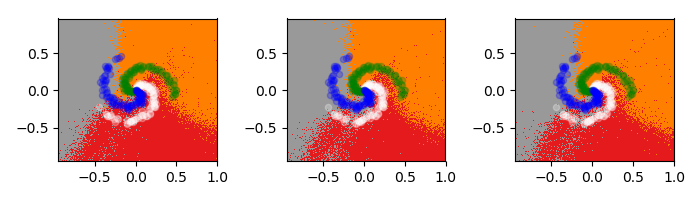

In [10]:
predictive = pyro.infer.Predictive(model, 
                                   guide=guide, 
                                   num_samples=1000)

samples = predictive(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))


# print(samples["obs"].shape)

plots = 3
fig, ax = plt.subplots(1, plots, figsize=(7, 2), tight_layout=True)

for i in range(plots):
    
    zz = samples["obs"][i].reshape(xx.shape).detach().numpy()
    # zz = samples["obs"].detach().numpy()
    ax[i].pcolormesh(xx, yy, zz, cmap=plt.cm.Set1)

    for j, m in enumerate(["w", "g", "b"]):
        ax[i].scatter(X[y==j, 0], X[y==j, 1], c=m, s=20, alpha=0.25)

In the plots, there is different sampling of the posterior, getting different predictions of the classes.

As it can see, the NN can clasify the differents classes, but in the borders are very confused and not clear what class is each one.

In the red one class, there is a miss classification between red and gray class, and it can be because of various reasons, maybe the archiquecture, the epochs. So in order to improve, it can try differents architechtures or number of epochs.

I trained the NN using different number of ecpoch, and the more epoch it trained, the more capable the NN can classify differents classes. 

The training can be improved adding training / validation / testing data split. So while it is training with training data, it can be evaluating the validation error, so it can stop the training before overfitting.

## Distribution of classes
As the histogram shows below, the class distribution is balanced, so It can uses accuracy as a classification metric.

<IPython.core.display.Javascript object>


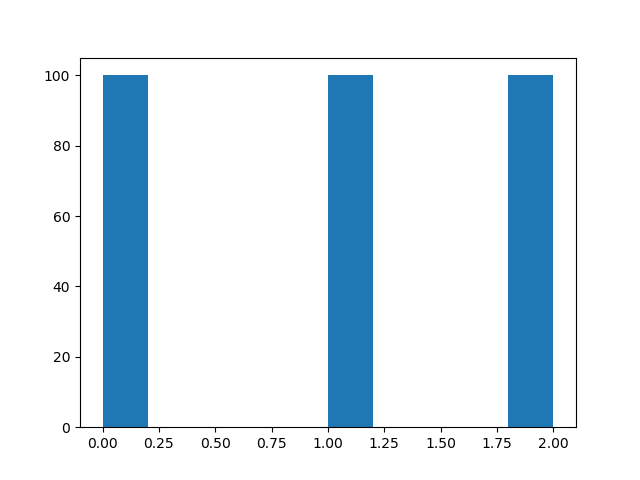

(array([100.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0., 100.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

In [11]:
fig, ax = plt.subplots()
ax.hist(y_train)

It gets the mode for each observation (because it has 1000 samples for same observation), and the mode is considered as the prediction for each observation

In [12]:
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = stats.mode(predictive(x_train)["obs"] , axis=0).mode[0][:]
y_true = y_train

# getting matrix confusion
ELBO_conf_matrix = confusion_matrix(y_true, y_pred)
ELBO_accuracy = accuracy_score(y_true, y_pred)

print("accuracty elbo: ", ELBO_accuracy)

print(ELBO_conf_matrix)

accuracty elbo:  0.9266666666666666
[[89  7  4]
 [ 0 91  9]
 [ 1  1 98]]


## Compare with the  𝛼  divergence objective, explore the influence of  𝛼  in the results

In this trainig, It keeps the same parameters (and NN model), only changing the loss function.

In [13]:
# Define model
pyro.enable_validation(True)
pyro.clear_param_store()
model = leo_bayesian(num_hidden = 10, prior_std = 1.)

# define guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model, init_scale=1e-1)

# define SVI (model for training)
svi = pyro.infer.SVI(model,
                    guide,
                    optim=pyro.optim.ClippedAdam({'lr':1e-2}),
                    
                    # using alpha divergence
                    loss=pyro.infer.RenyiELBO()
                    )

# n_epochs = 3000
n_epochs = 1000

# Training
epoch_loss = np.zeros(shape=(n_epochs,))

for epoch in tqdm(range(len(epoch_loss))):
    
    #print(epoch)
    
    epoch_loss[epoch] = svi.step(x_train, y_train)

## Visualizing results in data space

It takes 1000 samples from posterior

<IPython.core.display.Javascript object>


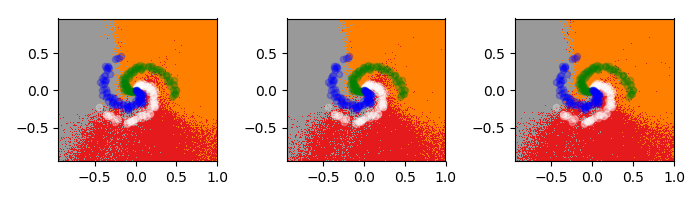

In [14]:
predictive = pyro.infer.Predictive(model, 
                                   guide=guide, 
                                   num_samples=1000)

samples = predictive(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))


# print(samples["obs"].shape)

plots = 3
fig, ax = plt.subplots(1, plots, figsize=(7, 2), tight_layout=True)

for i in range(plots):
    
    zz = samples["obs"][i].reshape(xx.shape).detach().numpy()
    # zz = samples["obs"].detach().numpy()
    ax[i].pcolormesh(xx, yy, zz, cmap=plt.cm.Set1)

    for j, m in enumerate(["w", "g", "b"]):
        ax[i].scatter(X[y==j, 0], X[y==j, 1], c=m, s=20, alpha=0.25)

The plots display different samples from the posterior, getting different classifications for each NN.

This model was trained with more epoch than before one, and this is also getting an area with "bad classifications", and this is the orange one (this has gray classes). This can be because of architecture, the epochs, the parameters.

From the graphic, it can see that the model can classify the classes correctly, and maybe there is a little of overfitting.

In [23]:
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = stats.mode(predictive(x_train)["obs"] , axis=0).mode[0][:]
y_true = y_train

# getting matrix confusion
ALPHA_conf_matrix = confusion_matrix(y_true, y_pred)
ALPHA_accuracy = accuracy_score(y_true, y_pred)

print("accuracy alpha: ", ALPHA_accuracy)
print(ALPHA_conf_matrix)

accuracy alpha:  0.9033333333333333
[[79 17  4]
 [ 0 94  6]
 [ 0  2 98]]


### Comparing conventional elbo and alpha divergence
Comparing the accuracies of elbo and alpha, elbo gets a higher accuracy than alpha (with default values) (92,6 for elbo and 90,3 for alpha). The same situation is for confusion matrix, where it can sees elbo has better classification results.

# Analizyng alpha values in training NN

## Alpha value smaller than 1

In [25]:
# Define model
pyro.enable_validation(True)
pyro.clear_param_store()
model = leo_bayesian(num_hidden = 10, prior_std = 1.)

# define guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model, init_scale=1e-1)

# define SVI (model for training)
svi = pyro.infer.SVI(model,
                    guide,
                    optim=pyro.optim.ClippedAdam({'lr':1e-2}),
                    
                    # using alpha divergence
                    loss=pyro.infer.RenyiELBO(alpha = 0.1)
                    )

# n_epochs = 3000
n_epochs = 1000

# Training
epoch_loss = np.zeros(shape=(n_epochs,))

for epoch in tqdm(range(len(epoch_loss))):
    
    #print(epoch)
    
    epoch_loss[epoch] = svi.step(x_train, y_train)

## Visualizing results in data space

It takes 1000 samples from posterior

<IPython.core.display.Javascript object>


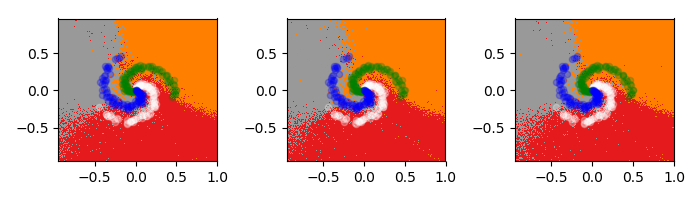

In [26]:
predictive = pyro.infer.Predictive(model, 
                                   guide=guide, 
                                   num_samples=1000)

samples = predictive(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))


# print(samples["obs"].shape)

plots = 3
fig, ax = plt.subplots(1, plots, figsize=(7, 2), tight_layout=True)

for i in range(plots):
    
    zz = samples["obs"][i].reshape(xx.shape).detach().numpy()
    # zz = samples["obs"].detach().numpy()
    ax[i].pcolormesh(xx, yy, zz, cmap=plt.cm.Set1)

    for j, m in enumerate(["w", "g", "b"]):
        ax[i].scatter(X[y==j, 0], X[y==j, 1], c=m, s=20, alpha=0.25)

In [28]:
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = stats.mode(predictive(x_train)["obs"] , axis=0).mode[0][:]
y_true = y_train

# getting matrix confusion
ALPHA_conf_matrix = confusion_matrix(y_true, y_pred)
ALPHA_accuracy = accuracy_score(y_true, y_pred)

print("accuracy alpha: ", ALPHA_accuracy)
print(ALPHA_conf_matrix)

accuracy alpha:  0.94
[[89  8  3]
 [ 0 98  2]
 [ 4  1 95]]


With alpha smaller than 1, 0.1, it gets better results than conventional ELBO, because now it gets 94 % compared to 92,4 % for elbo.

## Alpha value greather than 1

In [29]:
# Define model
pyro.enable_validation(True)
pyro.clear_param_store()
model = leo_bayesian(num_hidden = 10, prior_std = 1.)

# define guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model, init_scale=1e-1)

# define SVI (model for training)
svi = pyro.infer.SVI(model,
                    guide,
                    optim=pyro.optim.ClippedAdam({'lr':1e-2}),
                    
                    # using alpha divergence
                    loss=pyro.infer.RenyiELBO(alpha = 2)
                    )

# n_epochs = 3000
n_epochs = 1000

# Training
epoch_loss = np.zeros(shape=(n_epochs,))

for epoch in tqdm(range(len(epoch_loss))):
    
    #print(epoch)
    
    epoch_loss[epoch] = svi.step(x_train, y_train)

## Visualizing results in data space

It takes 1000 samples from posterior

<IPython.core.display.Javascript object>


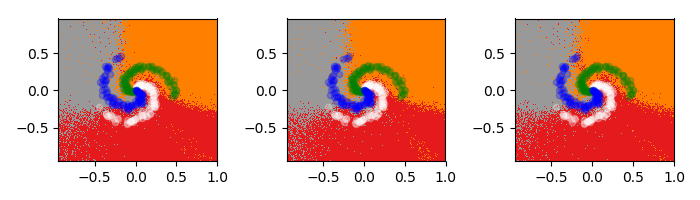

In [30]:
predictive = pyro.infer.Predictive(model, 
                                   guide=guide, 
                                   num_samples=1000)

samples = predictive(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))


# print(samples["obs"].shape)

plots = 3
fig, ax = plt.subplots(1, plots, figsize=(7, 2), tight_layout=True)

for i in range(plots):
    
    zz = samples["obs"][i].reshape(xx.shape).detach().numpy()
    # zz = samples["obs"].detach().numpy()
    ax[i].pcolormesh(xx, yy, zz, cmap=plt.cm.Set1)

    for j, m in enumerate(["w", "g", "b"]):
        ax[i].scatter(X[y==j, 0], X[y==j, 1], c=m, s=20, alpha=0.25)

In [31]:
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = stats.mode(predictive(x_train)["obs"] , axis=0).mode[0][:]
y_true = y_train

# getting matrix confusion
ALPHA_conf_matrix = confusion_matrix(y_true, y_pred)
ALPHA_accuracy = accuracy_score(y_true, y_pred)

print("accuracy alpha: ", ALPHA_accuracy)
print(ALPHA_conf_matrix)

accuracy alpha:  0.94
[[93  4  3]
 [ 1 95  4]
 [ 6  0 94]]


For this case, it gets 94 % accuracy, same value with smaller than 1 value to alpha.

## Conclusions
It could to:

- Train a NN for the given dataset
- Train a NN using conventional ElBO
- Train NN using alpha divergence
- Compare conventional ELBO with alpha
- Analyze differents values of alpha in training NN

Based on obtained results, there is difference between training with ELBO and Alpha. For this case, it gets the next results:
- ELBO: 92,6 % accuracy
- Alpha default: 90,3 % accuracy
- Alpha with 0.1: 94 % accuracy
- Alpha with 2: 94 % accuracy.

So from the obtained results, the best results were with alpha divergence with values smaller and greater than 1. 